In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas
import pickle
import glob
import re
from scipy import interpolate
import matplotlib as mpl
from matplotlib import ticker, cm
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

In [2]:
files = glob.glob('CLOSER/*.dat')
print(files)

['CLOSER/closer_CG_05242023_7TURNS.dat', 'CLOSER/closer_CG_05242023_6TURNS.dat', 'CLOSER/closer_CG_05242023_15TURNS.dat', 'CLOSER/closer_CG_05242023_14TURNS.dat', 'CLOSER/closer_CG_05242023_12TURNS.dat', 'CLOSER/closer_CG_05242023_13TURNS.dat', 'CLOSER/closer_CG_05242023_4TURNS.dat', 'CLOSER/closer_CG_05242023_5TURNS.dat', 'CLOSER/closer_CG_05242023_16TURNS.dat', 'CLOSER/closer_CG_05242023_17TURNS.dat', 'CLOSER/closer_CG_05242023_3TURNS.dat', 'CLOSER/closer_CG_05242023_2TURNS.dat', 'CLOSER/closer_CG_05242023_11TURNS.dat', 'CLOSER/closer_CG_05242023_10TURNS.dat', 'CLOSER/closer_CG_05242023_9TURNS.dat', 'CLOSER/closer_CG_05242023_8TURNS.dat']


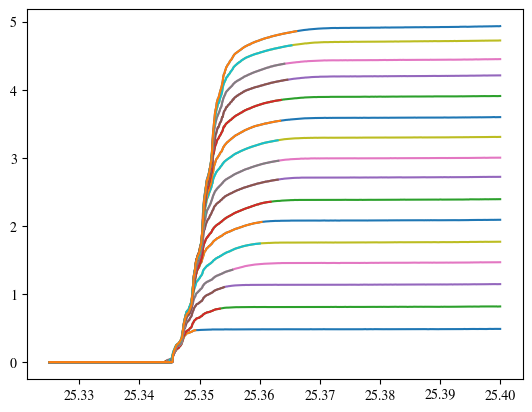

In [3]:
i = 0

boosterturns = np.arange(2,18)

tuneshifts = []
ppbs = []

for boosterturnsi in boosterturns:
    
    file = 'CLOSER/closer_CG_05242023_%dTURNS.dat'%boosterturnsi
    
    ifile = open(file, 'rb')
    data = pickle.load(ifile, encoding="bytes")
    
    htune = []
    vtune = []
    
    time = []
    rbeam = []
    
    for measurement in data.keys():
        
        vtune.append(data[measurement][b'vtune'])
        htune.append(data[measurement][b'htune'])
    
        timei = np.array(data[measurement][b'time'])
        rbeami = np.array(data[measurement][b'beam'])
        
        mask1 = (timei>=0.035)*(timei<=0.8)
        #mask2 = rbeami>0.01
        mask = mask1#*mask2
        
        timeimasked = timei[mask]
        rbeamimasked = rbeami[mask]
        
        rbeaminti = interpolate.interp1d(timeimasked, rbeamimasked, 
                                         bounds_error=False,
                                         kind = 'nearest-up',
                                         fill_value=(rbeamimasked[0], rbeamimasked[-1]))
        
        timeifinal = np.arange(0.035,0.8,0.001)
        rbeamifinal = rbeaminti(timeifinal)
        
        #axs[i].plot(timeifinal,rbeamifinal,'o',markersize=1)
        #axs[i].plot(timeimasked,np.gradient(rbeamimasked))
        
        time.append(timeifinal)
        rbeam.append(rbeamifinal)
        
    #print(htune,vtune)
    htune = np.mean(htune,axis=0)
    vtune = np.mean(vtune,axis=0)
    
    timeave = np.mean(time,axis=0)
    rbeamave = np.mean(rbeam,axis=0)
    rbeamave[rbeamave<0.02*np.max(rbeamave)] = 0
    rbeamave = rbeamave[10:]
    
    steps = len(rbeamave)
    htuneplot = np.linspace(np.min(htune),np.max(htune),steps)[::-1]
    
    # Calculate space charge tune shift
    if boosterturnsi in [2,3,4,5]:
        rightmask = np.gradient(rbeamave)/np.max(rbeamave)<-0.003*(1-boosterturnsi/18)
    else:
        rightmask = rbeamave<(1-0.015)*np.max(rbeamave)
    
    #rightmask = np.gradient(rbeamave)/np.max(rbeamave)<-0.003*(1-boosterturnsi/18)
    rightint = rbeamave[rightmask][-1]
    righttune = htuneplot[rightmask][0]
    
    leftmask = rbeamave>0
    leftint = rbeamave[leftmask][-1]
    lefttune = htuneplot[leftmask][-1]
    
    # print(righttune)
    # print(lefttune)
    # print(righttune-lefttune)
    
    tuneshifts.append(righttune-lefttune)
    
    # plt.plot(htuneplot,(np.gradient(rbeamave)/np.max(rbeamave)))
    # plt.ylim(-0.004,0)
    plt.plot( htuneplot,rbeamave)
    plt.plot( htuneplot[rightmask],rbeamave[rightmask])
    
    totalrbeam = np.max(rbeamave)*1e12
    ppb = totalrbeam/81
    ppbs.append(ppb)
    
    #break
    
    i=i+1

#tuneshift[0]=    
#tuneshifts[-1]=tuneshifts[-2]+0.0005

In [4]:
lefttune

np.float64(25.3455905621565)

In [5]:
rightint

np.float64(0.0)

In [6]:
import pandas as pd
bdata = pd.read_csv('emittance.csv')

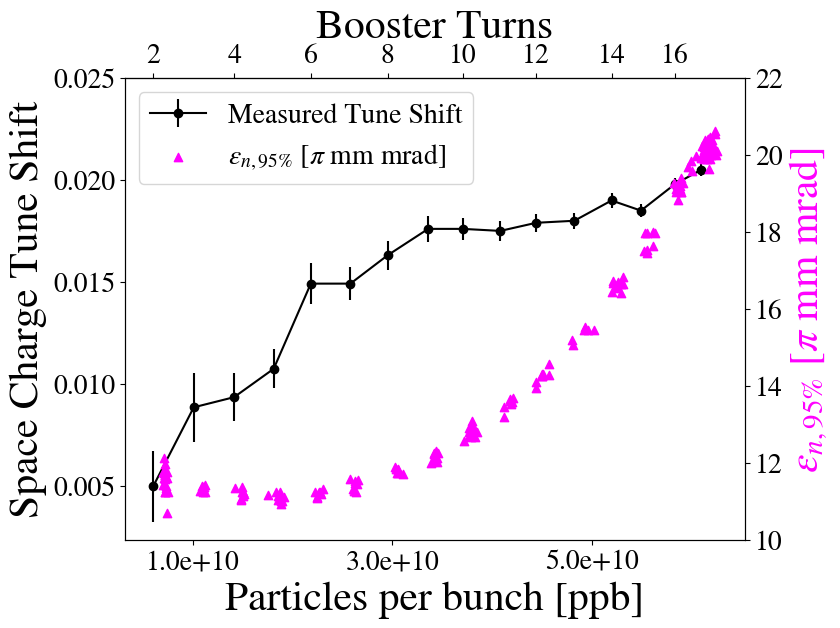

In [7]:
fig,ax = plt.subplots(1,1, figsize = (8,6))

# First axis
ax.errorbar(ppbs,tuneshifts, yerr=np.divide(tuneshifts,np.array(boosterturns)**1.5),
            fmt = '-o',color = 'black', label = 'Measured Tune Shift')

ax.set_xlabel('Particles per bunch [ppb]',fontsize=30)

ax.set_ylabel('Space Charge Tune Shift',fontsize=30)

ax.set_yticks(np.arange(0.005,0.026,0.005))
ax.ticklabel_format(style='sci', axis='x')
ax.tick_params(axis='both', labelsize=20)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
ax.set_xticks(np.arange(1,9,2)*1e10)

fun1inv = interpolate.interp1d(boosterturns,ppbs,fill_value='extrapolate')
fun1 = interpolate.interp1d(ppbs,boosterturns,fill_value='extrapolate')
twin1 = ax.secondary_xaxis('top',functions=(fun1,fun1inv))
twin1.set_xticks(np.arange(2,17,2))
twin1.tick_params(axis= 'x',labelsize = 20)
twin1.set_xlabel('Booster Turns',fontsize=30)

ax2=ax.twinx()
ax2.set_ylabel(r'$\epsilon_{n,95\%}$ [$\pi$ mm mrad]', fontsize = 30,color = 'fuchsia')
ax2.scatter(bdata['intensity']*1e12/81,bdata['MW104'], label =r'$\epsilon_{n,95\%}$ [$\pi$ mm mrad]', 
            marker = '^',color ='fuchsia')
ax2.set_ylim(10,22)
ax2.tick_params(axis= 'y',labelsize = 20)

h1,l1 = ax.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()

ax.legend(h1+h2, l1+l2, loc = 'upper left', fontsize = 20)

plt.show()
plt.close()

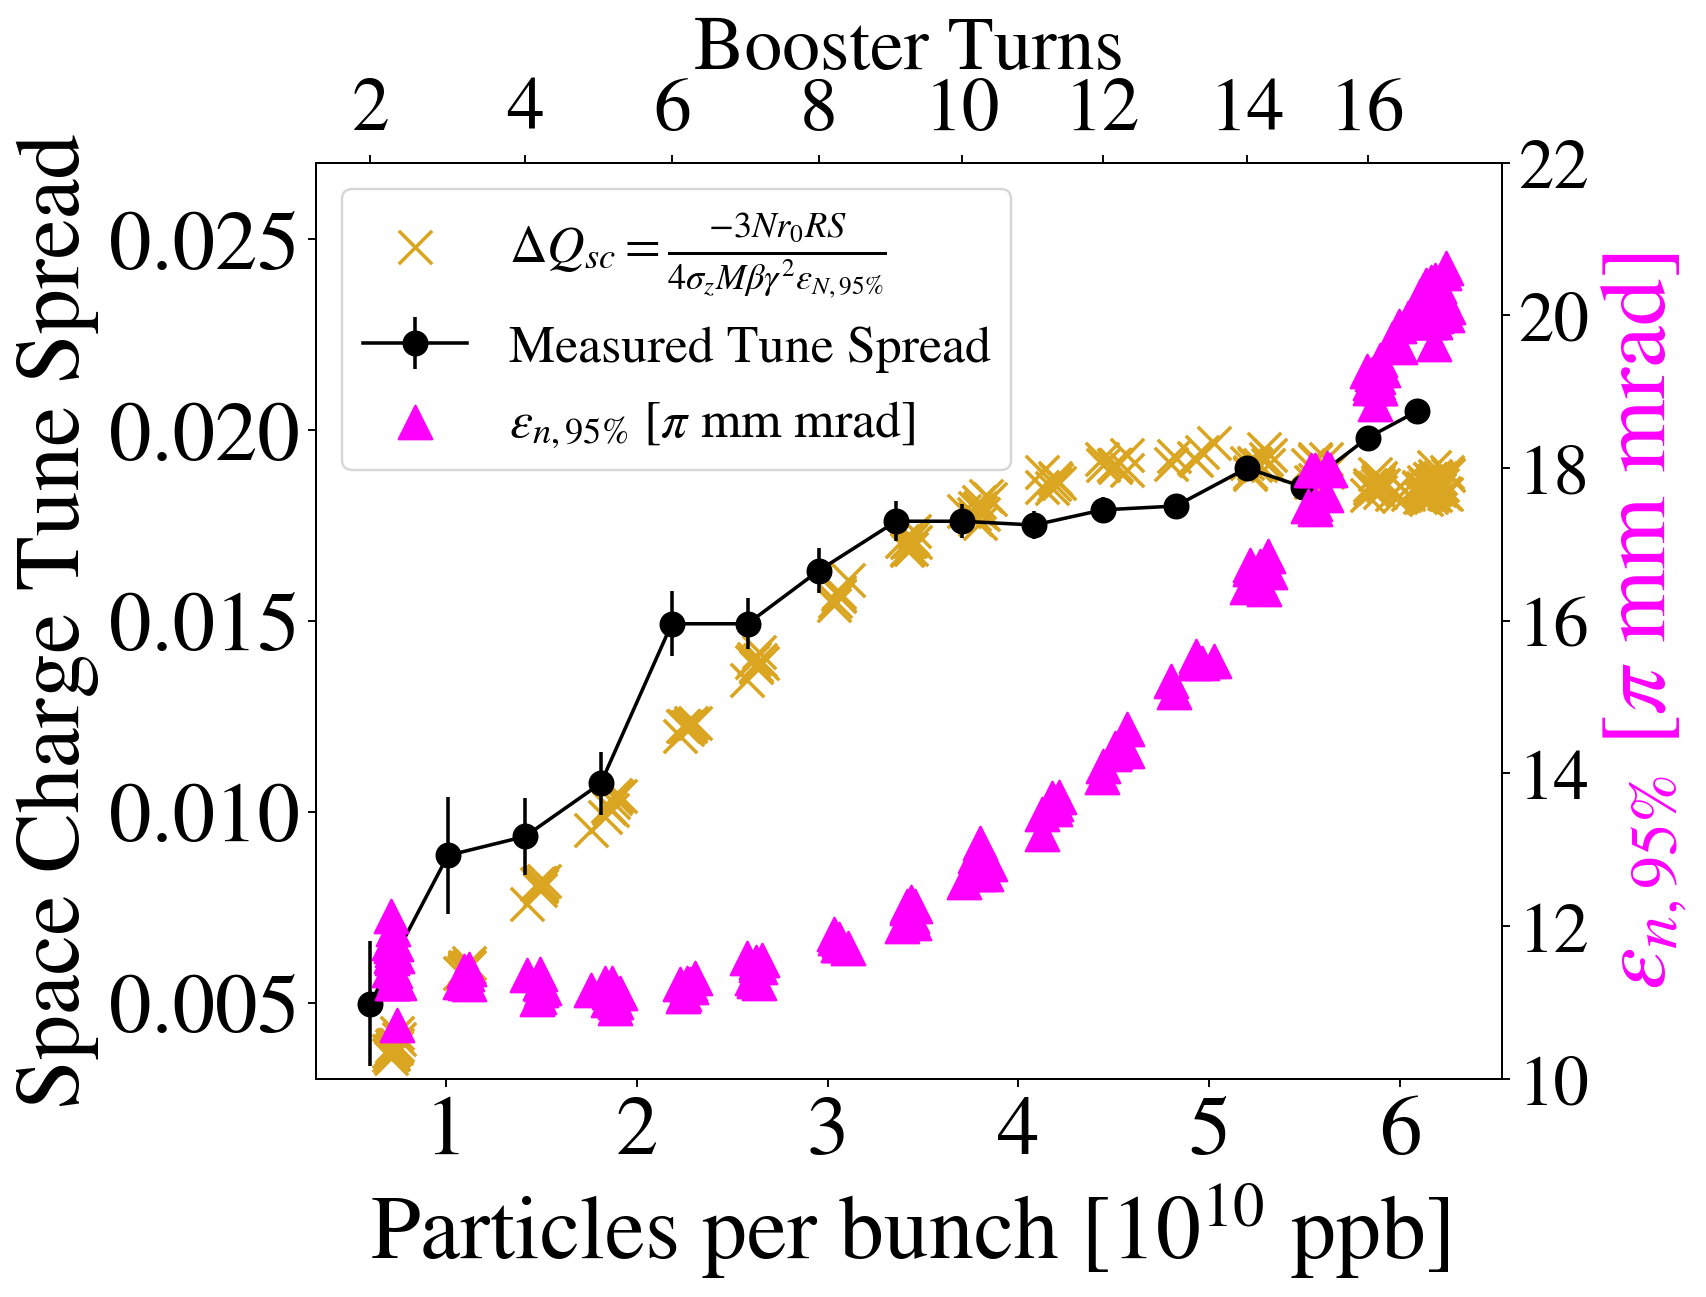

In [31]:
fig,ax = plt.subplots(1,1, figsize = (9,7))
fig.set_dpi(170)
# First axis
ax.errorbar(np.array(ppbs)/1e10,tuneshifts, yerr=np.divide(tuneshifts,np.array(boosterturns)**1.6),
            fmt = '-o',color = 'black', label = 'Measured Tune Spread',markersize = 10)

ax.scatter(bdata['intensity']*1e12/(81*1e10),-bdata['tuneshifts'], 
           marker = 'x', color = 'goldenrod', s = 200,
           label = r'$\Delta Q_{sc}=\frac{-3 N r_0 R S}{4 \sigma_z M \beta \gamma ^2 \varepsilon_{N,95\%}}$')

ax.set_xlabel('Particles per bunch [$10^{10}$ ppb]',fontsize=38)

ax.set_ylabel('Space Charge Tune Spread',fontsize=38)

ax.set_ylim(0.003,0.027)

ax.set_yticks(np.arange(0.005,0.026,0.005))
# ax.ticklabel_format(style='sci', axis='x')
ax.tick_params(axis='both', labelsize=36)
# ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
ax.set_xticks(np.arange(1,9,1))

fun1inv = interpolate.interp1d(boosterturns,np.array(ppbs)/1e10,fill_value='extrapolate')
fun1 = interpolate.interp1d(np.array(ppbs)/1e10,boosterturns,fill_value='extrapolate')
twin1 = ax.secondary_xaxis('top',functions=(fun1,fun1inv))
twin1.set_xticks(np.arange(2,17,2))
twin1.tick_params(axis= 'x',labelsize = 32)
twin1.set_xlabel('Booster Turns',fontsize=32)

ax2=ax.twinx()
ax2.set_ylabel(r'$\epsilon_{n,95\%}$ [$\pi$ mm mrad]', fontsize = 40,color = 'fuchsia')
ax2.scatter(bdata['intensity']*1e12/(81*1e10),bdata['MW104'], label =r'$\epsilon_{n,95\%}$ [$\pi$ mm mrad]', 
            marker = '^',color ='fuchsia', s =200)
ax2.set_ylim(10,22)
ax2.tick_params(axis= 'y',labelsize = 30)

h1,l1 = ax.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()

ax.legend(h1+h2, l1+l2, loc = 'upper left', fontsize = 22)

plt.show()
plt.close()

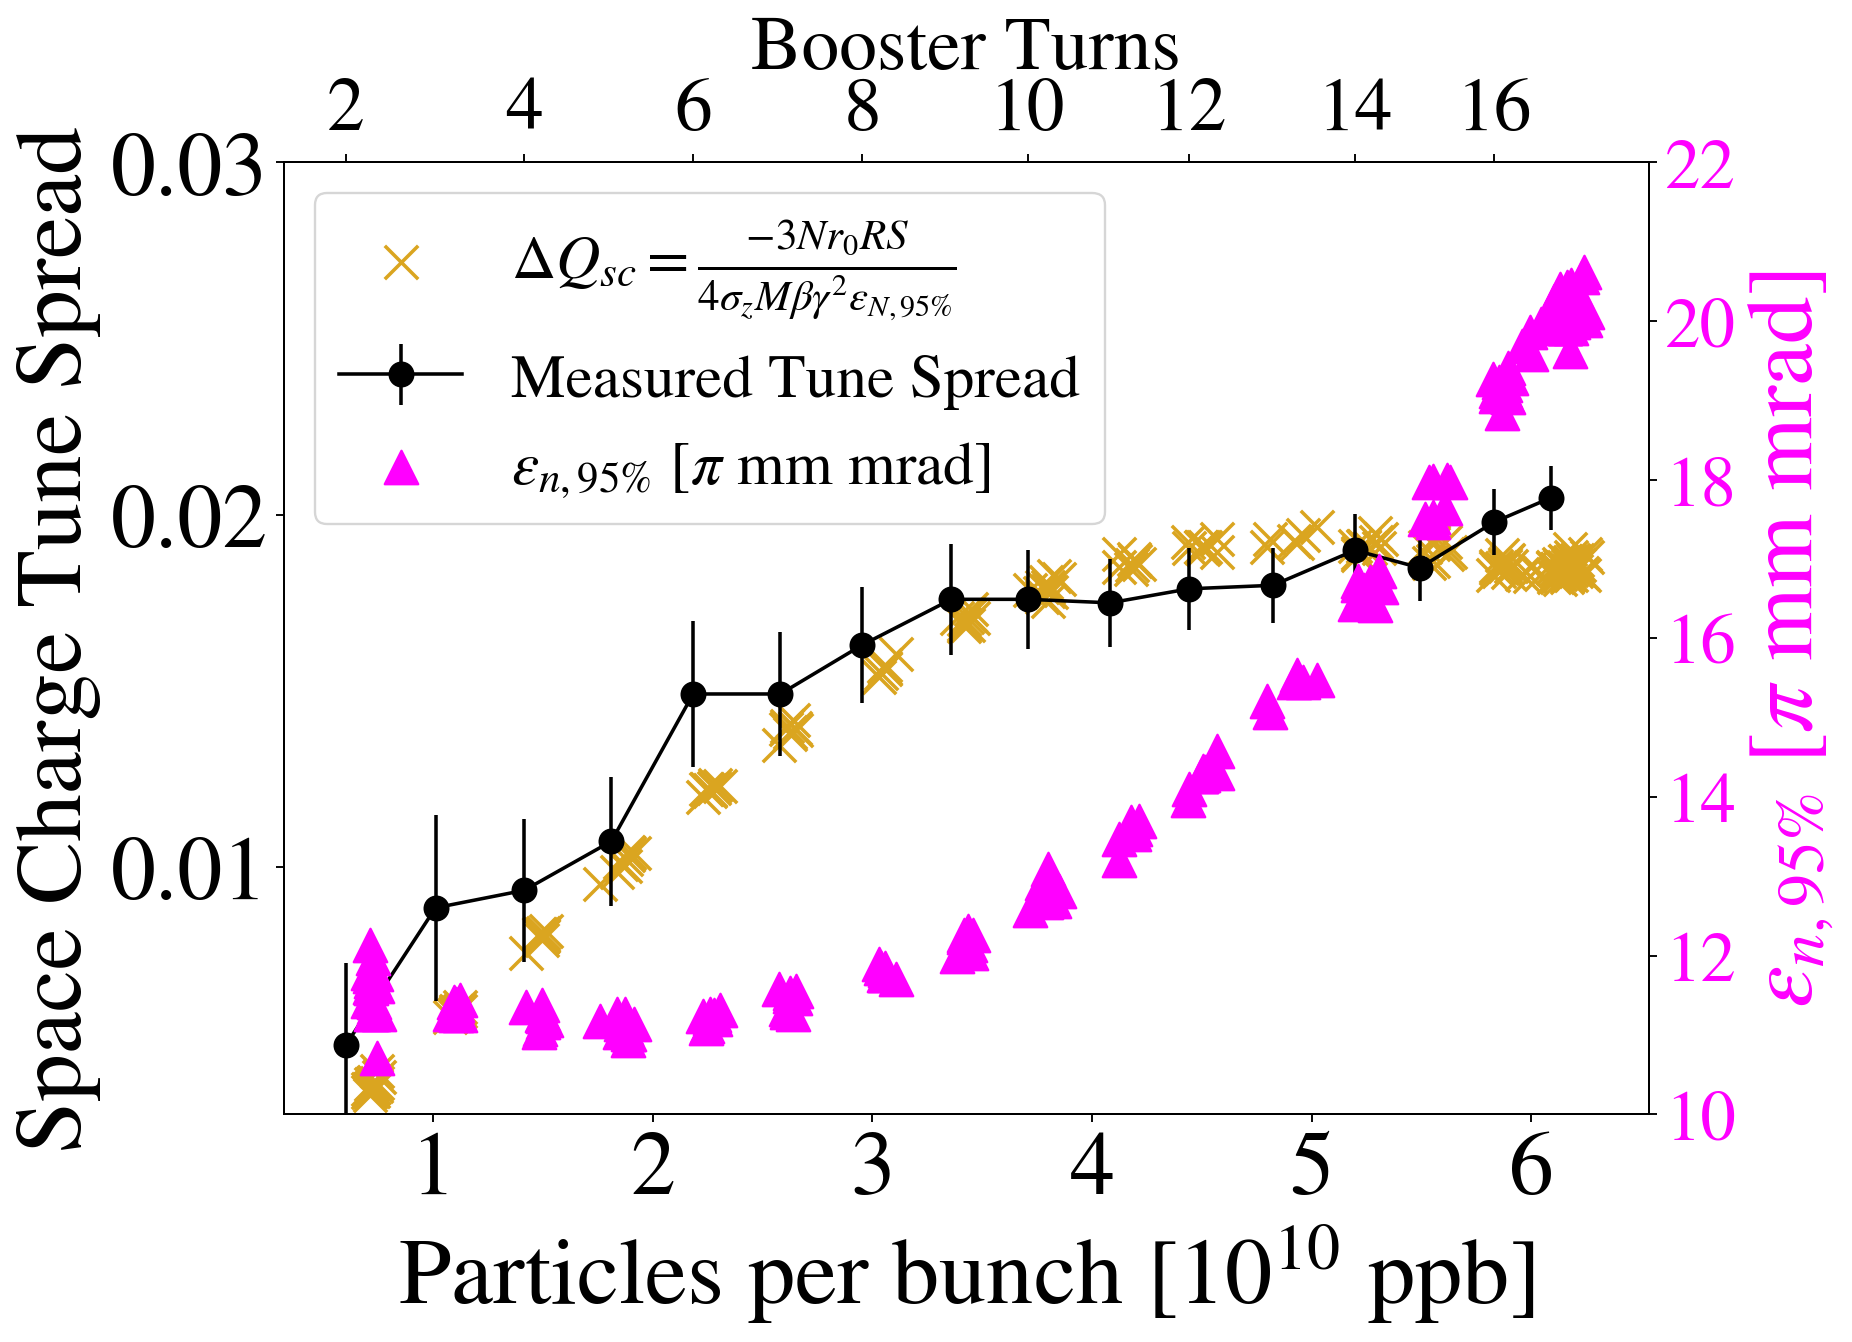

In [58]:
fig,ax = plt.subplots(1,1, figsize = (11,8))
fig.set_dpi(170)
# First axis
ax.errorbar(np.array(ppbs)/1e10,tuneshifts, yerr=np.divide(tuneshifts,np.array(boosterturns)**1.1),
            fmt = '-o',color = 'black', label = 'Measured Tune Spread',markersize = 10)

ax.scatter(bdata['intensity']*1e12/(81*1e10),-bdata['tuneshifts'], 
           marker = 'x', color = 'goldenrod', s = 200,
           label = r'$\Delta Q_{sc}=\frac{-3 N r_0 R S}{4 \sigma_z M \beta \gamma ^2 \varepsilon_{N,95\%}}$')

ax.set_xlabel('Particles per bunch [$10^{10}$ ppb]',fontsize=40)

ax.set_ylabel('Space Charge Tune Spread',fontsize=40)

ax.set_ylim(0.003,0.03)

# ax.set_yticks(np.arange(0.005,0.027,0.005))
# ax.ticklabel_format(style='sci', axis='x')
ax.tick_params(axis='both', labelsize=38)
# ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
ax.set_xticks(np.arange(1,9,1))

fun1inv = interpolate.interp1d(boosterturns,np.array(ppbs)/1e10,fill_value='extrapolate')
fun1 = interpolate.interp1d(np.array(ppbs)/1e10,boosterturns,fill_value='extrapolate')
twin1 = ax.secondary_xaxis('top',functions=(fun1,fun1inv))
twin1.set_xticks(np.arange(2,17,2))
twin1.tick_params(axis= 'x',labelsize = 32)
twin1.set_xlabel('Booster Turns',fontsize=32)

ax2=ax.twinx()
ax2.set_ylabel(r'$\epsilon_{n,95\%}$ [$\pi$ mm mrad]', fontsize = 40,color = 'fuchsia')
ax2.scatter(bdata['intensity']*1e12/(81*1e10),bdata['MW104'], label =r'$\epsilon_{n,95\%}$ [$\pi$ mm mrad]', 
            marker = '^',color ='fuchsia', s =200)
ax2.set_ylim(10,22)
ax2.tick_params(axis= 'y',labelsize = 30,labelcolor = 'fuchsia')

h1,l1 = ax.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()

ax.legend(h1+h2, l1+l2, loc = 'upper left', fontsize = 26)

plt.tight_layout()
plt.savefig('tune_spread.pdf')

plt.show()
plt.close()

In [162]:
np.array(ppbs)/10**12

array([0.06026337, 0.10097119, 0.14139918, 0.18111111, 0.21831276,
       0.25802469, 0.29539095, 0.33596708, 0.37069959, 0.4082716 ,
       0.44423868, 0.48246914, 0.51979424, 0.54930041, 0.58312757,
       0.6091358 ])

In [173]:
np.arange(0.005,0.026,0.005)

array([0.005, 0.01 , 0.015, 0.02 , 0.025])

In [12]:
np.arange(1,8,2)

array([1, 3, 5, 7])

In [19]:
np.arange(1,8,2)*1e10

array([1.e+10, 3.e+10, 5.e+10, 7.e+10])

In [61]:
boosterturns

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

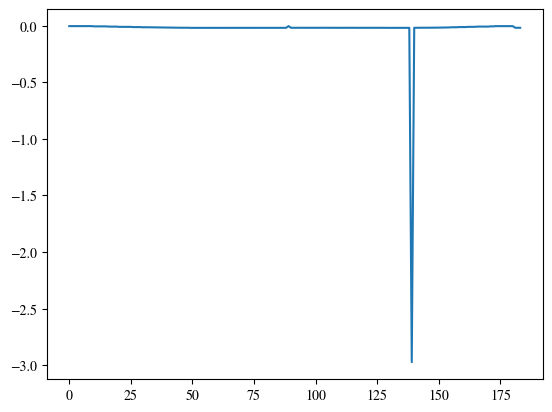

In [94]:
plt.plot(bdata['tuneshifts'])
plt.ylim(

In [90]:
bdata

,Unnamed: 0,intensity,MW102_h,MW829,booster_turns,MW826,MW827,MW102_v,MW836,MW851,MW104,MW850,MW852,MW853,MW103,tuneshifts
0,0,0.575493,2.545705,8.298994,2.0,8.009361,7.895501,0.206943,13.148484,0.153117,11.606292,12.558543,0.008567,14.079012,7.098767,-0.003704
1,2,0.603800,2.641048,8.362989,2.0,8.108982,7.822971,0.206758,13.304267,0.153435,10.701833,14.390001,3.667749,14.324846,7.176121,-0.004215
2,7,0.586816,2.521283,8.436961,2.0,8.043678,7.944270,0.205643,13.174905,0.148282,11.702215,12.214876,0.016656,14.219312,6.932978,-0.003746
3,8,0.609461,2.574076,8.457971,2.0,8.212070,7.870743,0.218947,13.470060,0.140816,11.261277,13.275146,0.013249,14.465901,7.029169,-0.004043
4,9,0.586816,2.601075,8.409230,2.0,8.153228,7.877203,0.205687,13.312928,0.155558,11.967373,11.822147,0.005963,14.272048,7.123790,-0.003663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,294,0.581155,2.653641,8.142938,2.0,7.933193,7.686767,0.206443,13.388016,0.155242,11.261646,13.138258,0.004762,16.093468,6.616379,-0.003855
180,295,0.586816,2.696693,8.461822,2.0,8.159650,7.829993,0.205363,13.388023,0.148868,11.257407,13.693727,0.012465,16.998109,6.932770,-0.003894
181,296,4.753496,4.673064,16.727681,16.0,16.203467,15.856830,15.436021,21.057025,17.072456,19.206169,17.439883,0.011186,21.461654,14.494918,-0.018488
182,297,4.753496,4.585444,16.508937,16.0,15.922773,15.458055,15.048477,19.870518,16.653998,18.837882,17.128331,0.011681,21.201337,14.116803,-0.018850
